# What is this?

This is a starter notebook for those who wish to train DRL models for Kore 2022 using genetic algorithms. For the sake of simplicity, this example handles a very short action space that is limited to a single shipyard and the following actions:

- Do nothing.
- Spawn one ship.
- Launch a fleet with a single character flight plan ("N", "E", "W" or "S") using all ships
- Launch a fleet with a single character flight plan using half of the ships

Also, for this agent, we make a few assumptions for mapping actual Board values to our neural network observation:

- The maximum value of Kore in a single square is expected to be 500
- The maximum fleet size is expected to be 1000
- The maximum amount of Kore a fleet can carry is expected to be 5000

Just to reinforce: these are not actual rules for Kore 2022, we're just using them to map values to a known range.

Please take time to read the comments in code, they might help with understanding. Also, if you have any suggestions, please let me know in the comments!

In [1]:
%pip install pygad==2.16.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 202.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
from random import choice
from typing import Union

from gym import Env, spaces
from kaggle_environments import make
from kaggle_environments.envs.kore_fleets.helpers import (
    Board,
    Configuration,
    Observation,
    ShipyardAction,
)
import numpy as np
import pygad
import pygad.kerasga
from tensorflow.keras import models, layers

/opt/conda/lib/python3.7/site-packages/pygad/pygad.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  supported_int_types = [int, numpy.int, numpy.int8, numpy.int16, numpy.int32, numpy.int64, numpy.uint, numpy.uint8, numpy.uint16, numpy.uint32, numpy.uint64]
/opt/conda/lib/python3.7/site-packages/pygad/pygad.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use 

# Create a custom environment



In [3]:
class CustomKoreEnv(Env):
    """
    This is a custom Kore environment, adapted for use with
    OpenAI Gym. We don't actually need to use OpenAI Gym in
    this example, but I've chosen to do it for the sake of
    compatibility for those who already have code for it.
    """

    metadata = {"render.modes": ["human"]}

    def __init__(self, agent2="random"):
        super().__init__()
        # Initialize the actual environment
        kore_env = make("kore_fleets", debug=True)
        self.env = kore_env.train([None, agent2])
        self.env_configuration: Configuration = kore_env.configuration
        map_size = self.env_configuration.size
        self.board: Board = None

        # Our observation space will be a matrix of size
        # (map_size, map_size, 4).
        #
        # - The first layer is the kore count, which has
        #   its values mapped to [0, 1]
        #
        # - The second layer is the fleet size, which has
        #   its values mapped to [-1, 1] (negative values
        #   are used to represent enemy fleets)
        #
        # - The third layer represents possible places that
        #   the enemy fleets can be at the next turn. All
        #   values are either -1 (enemy can be there) or
        #   0 (enemy can't be there).
        #
        # - The fourth layer represents the amount of kore
        #   that each fleet is carrying.
        #
        self.observation_space = spaces.Box(
            low=-1, high=1, shape=(map_size, map_size, 4), dtype=np.float64
        )

        # Our action space will be an array of shape (2,).
        #
        # - The following combinations will map to the
        #   respective actions:
        #
        #   - [0, 0] -> Do nothing
        #   - [0, 1] -> Build a new ship
        #   - [1, 0] -> Launch a fleet with a simple flight
        #     plan (e.g. N, E, S, W). All ships will be
        #     used to launch the fleet.
        #   - [1, 1] -> Same as [1, 0], but only half of the
        #     ships will be used to launch the fleet.
        #
        self.action_space = spaces.Box(low=0, high=1, shape=(2,), dtype=np.float64)

    def map_value(self, value: Union[int, float], enemy: bool = False,) -> float:
        """
        Helper function for build_observation. For this to work, we must
        assume the following:
            - The maximum value of Kore in a single square is expected to be
                500.
            - The maximum fleet size is expected to be 1000.
            - The maximum amount of kore a fleet can carry is expected to be
                5000.
        Maps a value to a range of [-1, 1] if enemy, or [0, 1] otherwise.
        """
        MAX_NATURAL_KORE_IN_SQUARE = 500
        MAX_ASSUMED_FLEET_SIZE = 1000
        MAX_ASSUMED_KORE_IN_FLEET = 5000
        max_value = float(
            max(
                MAX_NATURAL_KORE_IN_SQUARE,
                MAX_ASSUMED_FLEET_SIZE,
                MAX_ASSUMED_KORE_IN_FLEET,
            )
        )
        val = value / max_value
        if enemy:
            return -val
        return val

    def build_observation(self, raw_observation: Observation) -> np.ndarray:
        """
        Our observation space will be a matrix of size
        (map_size, map_size, 4).
        
        - The first layer is the kore count, which has
            its values mapped to [0, 1]
        
        - The second layer is the fleet size, which has
            its values mapped to [-1, 1] (negative values
            are used to represent enemy fleets)
        
        - The third layer represents possible places that
            the enemy fleets can be at the next turn. All
            values are either -1 (enemy can be there) or
            0 (enemy can't be there).
        
        - The fourth layer represents the amount of kore
            that each fleet is carrying.
        """
        # Build the Board object that will help us build the layers
        board = Board(raw_observation, self.env_configuration)

        # Building the kore layer
        kore_layer = np.array(raw_observation.kore).reshape(
            self.env_configuration.size, self.env_configuration.size
        )

        # Building the fleet layer
        fleet_layer = np.zeros(
            (self.env_configuration.size, self.env_configuration.size)
        )
        # - Get fleets and shipyards on the map
        fleets = [fleet for _, fleet in board.fleets.items()]
        shipyards = [shipyard for _, shipyard in board.shipyards.items()]
        # - Iterate over fleets, getting its position and size
        for fleet in fleets:
            # - Get the position of the fleet
            position = fleet.position
            x, y = position.x, position.y
            # - Get the size of the fleet
            size = fleet.ship_count
            # - Check if the fleet is an enemy fleet
            if fleet.player != board.current_player:
                multilpier = -1
            else:
                multilpier = 1
            # - Set the fleet layer to the size of the fleet
            fleet_layer[x, y] = multilpier * self.map_value(size)
        # - Iterate over shipyards, getting its position and size
        for shipyard in shipyards:
            # - Get the position of the shipyard
            position = shipyard.position
            x, y = position.x, position.y
            # - Get the size of the shipyard
            size = shipyard.ship_count
            # - Check if the shipyard is an enemy shipyard
            if shipyard.player != board.current_player:
                multilpier = -1
            else:
                multilpier = 1
            # - Set the fleet layer to the size of the shipyard
            fleet_layer[x, y] = multilpier * self.map_value(size)

        # Building the enemy positions layer
        enemy_positions_layer = np.zeros(
            (self.env_configuration.size, self.env_configuration.size)
        )
        # - Iterate over fleets
        for fleet in fleets:
            # If fleet is ours, skip it
            if fleet.player == board.current_player:
                continue
            # - Get the position of the fleet
            position = fleet.position
            x, y = position.x, position.y
            # - Set the enemy positions layer to -1
            enemy_positions_layer[x, y] = -1
            enemy_positions_layer[x - 1, y] = -1
            if x + 1 >= self.env_configuration.size:
                enemy_positions_layer[0, y]
            else:
                enemy_positions_layer[x + 1, y] = -1
            enemy_positions_layer[x, y - 1] = -1
            if y + 1 >= self.env_configuration.size:
                enemy_positions_layer[x, 0]
            else:
                enemy_positions_layer[x, y + 1] = -1

        # Building the kore layer
        kore_layer = np.zeros(
            (self.env_configuration.size, self.env_configuration.size)
        )
        # - Iterate over fleets
        for fleet in fleets:
            # - Get the position of the fleet
            position = fleet.position
            x, y = position.x, position.y
            # - Get the amount of kore the fleet is carrying
            kore = fleet.kore
            # - Set the kore layer to the amount of kore
            kore_layer[x, y] = kore

        # Building our observation box
        observation = np.zeros(
            (self.env_configuration.size, self.env_configuration.size, 4)
        )
        observation[:, :, 0] = kore_layer
        observation[:, :, 1] = fleet_layer
        observation[:, :, 2] = enemy_positions_layer
        observation[:, :, 3] = kore_layer

        return observation

    def map_reward(
        self, old_reward: Union[int, float],
    ):
        """
        If you want to modify the reward, you can do it here.
        """
        return old_reward

    # def get_my_shipyard(self) -> Shipyard:
    #     """
    #     Returns the shipyard of the current player.
    #     """
    #     for shipyard in self.board.current_player.sh

    def match_action(self, action_space: np.ndarray) -> ShipyardAction:
        """
        This function will match the action space to a
        ShipyardAction.
        """
        # If there are no shipyards, return None
        if len(self.board.current_player.shipyards) == 0:
            return None
        action_space = np.round_(action_space[0], decimals=0).astype(int)
        # - Check if the action space is [0, 0]
        if action_space[0] == 0 and action_space[1] == 0:
            return None
        # - Check if the action space is [0, 1]
        elif action_space[0] == 0 and action_space[1] == 1:
            return ShipyardAction.spawn_ships(1)
        # - Check if the action space is [1, 0]
        elif action_space[0] == 1 and action_space[1] == 0:
            ships_in_fleet = self.board.current_player.shipyards[0].ship_count
            if ships_in_fleet == 0:
                return None
            return ShipyardAction.launch_fleet_with_flight_plan(
                self.board.current_player.shipyards[0].ship_count,
                choice(["N", "E", "S", "W"])
            )
        # - Check if the action space is [1, 1]
        elif action_space[0] == 1 and action_space[1] == 1:
            ships_in_fleet = int(self.board.current_player.shipyards[0].ship_count / 2)
            if ships_in_fleet == 0 and self.board.current_player.shipyards[0].ship_count > 0:
                ships_in_fleet = 1
            else:
                return None
            return ShipyardAction.launch_fleet_with_flight_plan(
                ships_in_fleet,
                choice(["N", "E", "S", "W"])
            )
        else:
            raise ValueError(f"Invalid action space: {action_space}")

    def reset(self):
        """
        Resets the environment.
        """
        self.raw_observation = self.env.reset()
        obs = self.build_observation(self.raw_observation)
        return obs

    def step(self, action_space: np.ndarray):
        """
        Performs an action in the environment.
        """
        # Get the Board object and update it
        self.board = Board(self.raw_observation, self.env_configuration)
        # Sets done if no shipyards are left
        if len(self.board.current_player.shipyards) == 0:
            return np.zeros((21, 21, 4)), 0, True, {}
        # Get the action for the shipyard
        action = self.match_action(action_space)
        self.board.current_player.shipyards[0].next_action = action
        self.raw_observation, old_reward, done, info = self.env.step(
            self.board.current_player.next_actions
        )
        observation = self.build_observation(self.raw_observation)
        reward = self.map_reward(old_reward)
        return observation, reward, done, info

# Set `build_model` and `build_env` functions

In [4]:
def build_env():
    return CustomKoreEnv()

def build_model():
    return models.Sequential(
        [
            layers.Input(shape=(21, 21, 4)),
            layers.Conv2D(64, 8),
            layers.Activation("linear"),
            layers.Conv2D(128, 10),
            layers.Activation("linear"),
            layers.Flatten(),
            layers.Dense(32),
            layers.Activation("linear"),
            layers.Dense(2),
            layers.Activation("sigmoid")
        ]
    )

# Set a fitness function and a generation callback

**Improvement hints**: Playing a single game is not really useful, as it might get lucky in it. If you really want to get the fitness of a model, you'd probably play a few games and return the average fitness. Also, playing against different opponents is recommended.

In [5]:
def fitness_func(solution, sol_idx):
    env = build_env()
    model = build_model()
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(
        model=model, weights_vector=solution
    )
    model.set_weights(weights=model_weights_matrix)

    observation = env.reset()
    sum_reward = 0
    done = False
    c = 0
    while (not done) and c < 400:
        observation = np.reshape(observation, [1, 21, 21, 4])
        action_space = model.predict(observation)
        observation_next, reward, done, info = env.step(action_space)
        observation = observation_next
        sum_reward += reward
        c += 1

    return sum_reward

def callback_generation(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")
    print(f"Best fitness: {ga_instance.best_solution()[1]}")

# Actually train it!

**Hint**: you might want to tinker a bit with those parameters and get deeper into them for better results.

2022-05-01 13:01:17.645269: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-01 13:01:18.709612: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Generation: 1
Best fitness: 5116.064625000001
Generation: 2
Best fitness: 7422.312999999999
Generation: 3
Best fitness: 6740.61371875
Generation: 4
Best fitness: 5116.064625000001
Generation: 5
Best fitness: 5272.56175


/opt/conda/lib/python3.7/site-packages/pygad/pygad.py:3142: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


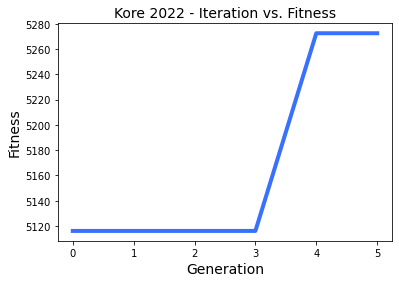

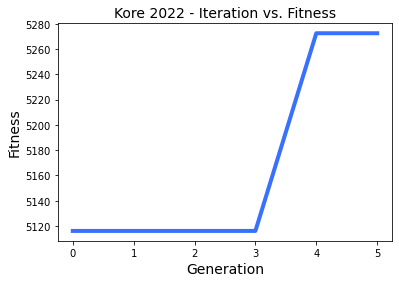

In [6]:
keras_ga = pygad.kerasga.KerasGA(model=build_model(), num_solutions=10)

num_generations = 5  # Number of generations.
num_parents_mating = (
    5  # Number of solutions to be selected as parents in the mating pool.
)
initial_population = (
    keras_ga.population_weights
)  # Initial population refers to the initial network weights
mutation_percent_genes = 10  # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_func,
    initial_population=initial_population,
    mutation_percent_genes=mutation_percent_genes,
    on_generation=callback_generation,
)

ga_instance.run()
ga_instance.plot_result(title="Kore 2022 - Iteration vs. Fitness", linewidth=4)

# Save your agent's model

**Hint**: you can save multiple models too and train future models against them!

In [7]:
# Getting the best solution and saving it.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(
    f"Fitness value of the best solution = {solution_fitness}"
)
print(f"Index of the best solution : {solution_idx}")

model = build_model()
model_weights_matrix = pygad.kerasga.model_weights_as_matrix(
    model=model, weights_vector=solution
)
model.set_weights(weights=model_weights_matrix)
model.save("genetic_kore")

Fitness value of the best solution = 5272.56175
Index of the best solution : 0


2022-05-01 13:24:08.302618: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Sample submission

This is what your submission file may look like. Just make sure that you'll have all dependencies here as well.

In [8]:
custom_env = CustomKoreEnv()
model: models.Sequential = models.load_model("genetic_kore")

def agent(obs: Observation, config: Configuration):
    model_observation = np.reshape(custom_env.build_observation(obs), [1, 21, 21, 4])
    action_space = model.predict(model_observation)
    # Iterate over shipyards
    board = Board(obs, config)
    custom_env.board = board
    if board.current_player.shipyards:
        board.current_player.shipyards[0].next_action = custom_env.match_action(action_space)
    return board.current_player.next_actions

# Play a game with it!

Let's do a quick sanity check and see if our model is really able to play this thing!

In [9]:
env = make("kore_fleets", debug=True)
env.run([agent, "random"])
env.render(mode="ipython", width=800, height=800)